<a href="https://colab.research.google.com/github/Nnamaka/Awesome-Super-Resolution/blob/master/Computer_vision/face_Detection/faceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 15 kB/s 
     |████████████████████████████████| 394.3 MB 19 kB/s 
     |████████████████████████████████| 132 kB 81.1 MB/s 
     |████████████████████████████████| 462 kB 86.1 MB/s 
     |████████████████████████████████| 14.8 MB 82.9 MB/s 
     |████████████████████████████████| 2.9 MB 57.6 MB/s 
     |████████████████████████████████| 3.8 MB 89.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=8215dc890f6e55b7a8f6fa2e6069de320086c0e7ad0b7b30e2030c825a4e3fd2
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Atte

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=66bfcb94583e17e26abb3c7169df2b6558e3b476a52576999752dad6cef2a77d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


##Import Dependencies

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

##Create Folder Structures


In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

#Collect Positive and Anchors.   
And preprocess them

  
My positive and anchor images were stored in my Google Drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
!cp "/content/drive/MyDrive/TFOD images/face.tar.gz" /content && cp "/content/drive/MyDrive/TFOD images/anchor.tar.gz" /content

uncompressed data file of positive image

In [8]:
!tar -xzf face.tar.gz && tar -xzf anchor.tar.gz

resize and store positive and anchor images in data folder, in their appropriate folders.

In [9]:
width = 250
height = 250
dim = (width, height)


In [10]:
anch_pos = ["/content/Anchor/","/content/Myimages"]

for path in anch_pos:
  for filename in os.listdir(path):
    if filename.endswith('.jpg'):
      try:
        if 'Anchor' in path:
          img = cv2.imread("/content/Anchor/" + filename, cv2.IMREAD_UNCHANGED)
          new_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
          cv2.imwrite(ANC_PATH + '/' + filename, new_img)

        if 'Myimages' in path:
          img = cv2.imread("/content/Myimages/" + filename, cv2.IMREAD_UNCHANGED)
          new_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
          cv2.imwrite(POS_PATH + '/' + filename, new_img)
      except:
        pass
      

Augument all positive and anchor images to increase data size and possible expose the model to newer samples

In [11]:
def augment(img):
  data = []
  for i in range(15):
    img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
    img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
    img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
    img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

    data.append(img)

  return data

In [12]:
import os
import uuid

In [13]:
paths = [POS_PATH, ANC_PATH]

for path in paths:
  print("inside " + path)
  for file_name in os.listdir(os.path.join(path)):
    img_path = os.path.join(path, file_name)
    img = cv2.imread(img_path)
    augmented_images = augment(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

inside data/positive
inside data/anchor


check the no of positive and anchor images

In [14]:
for path in paths:
  print("no of images in " + path + " : ", end="")
  a = 0
  for image in os.listdir(os.path.join(path)):
    if image.endswith('.jpg'):
      a = a + 1
  print(a)

no of images in data/positive : 480
no of images in data/anchor : 480


#Collect Negative Images

In [15]:
!wget -O wildImages.tar http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-09-24 17:39:57--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘wildImages.tar’

wildImages.tar      100%[===================>] 172.20M   104MB/s    in 1.7s    

2022-09-24 17:39:59 (104 MB/s) - ‘wildImages.tar’ saved [180566744/180566744]



###Untar Labelled Faces in the wild Dataset



In [16]:
!tar -xzf wildImages.tar

In [17]:
# move ifw images to the negative folder image directory
# a = 0
# no_of_neg_img = 450
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    # a = a + 1;

    # if ( a == no_of_neg_img):
    #   break

    old_path = os.path.join('lfw', directory, file)
    new_path = os.path.join(NEG_PATH, file)
    os.replace(old_path, new_path)

#Load and Preprocess Images

##Get image directories

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(450)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(450)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(450)


In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
print(dir_test.next())

b'data/anchor/e7ec657a-3c2f-11ed-8b70-0242ac1c0002.jpg'


#Preprocessing - Scale and Resize

In [21]:
def preprocess(file_Path):

  byte_img = tf.io.read_file(file_Path)

  img = tf.io.decode_jpeg(byte_img)

  img = tf.image.resize(img, (100, 100))
  img = img / 255.0

  return img

In [22]:
img = preprocess('data/anchor/IMG_20220920_152033_954.jpg')


In [23]:
img.numpy().max() 


1.0

#Create Labelled Dataset

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [25]:
samples = data.as_numpy_iterator()

In [26]:
example = samples.next()

In [27]:
example

(b'data/anchor/e7576394-3c2f-11ed-8b70-0242ac1c0002.jpg',
 b'data/positive/e5d6a732-3c2f-11ed-8b70-0242ac1c0002.jpg',
 1.0)

#Build Train and Test Partition

In [28]:
def preprocess_twin(input_img, validation_img, label):
  return( preprocess(input_img), preprocess(validation_img), label)

In [29]:
res = preprocess_twin(*example)

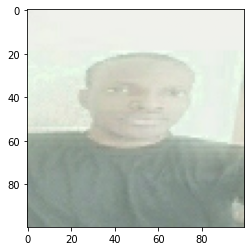

In [30]:
plt.imshow(res[1])

In [31]:
res[2]

1.0

Build dataloader and split data into train and test partition

In [32]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [33]:
# train partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [34]:
# test partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

#Model Engineering

##Build Embedding Layer   
create a function that creates our embedding layer

In [37]:
def make_embedding():
  inp = Input(shape=(100, 100,3), name='input_image')

  # block 1
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  # block 2
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # block 3
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # block 4
  c4 = Conv2D(128, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

###Build Distance layer

In [40]:
# siamese L1 Distance class
class L1Dist(Layer):

  def __init_(self, **kwargs):
    super().__inti__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [41]:
l1 = L1Dist()

##Make Siamese Model

In [42]:
def make_siamese_model():

  input_image = Input(name='input_img', shape=(100, 100, 3))

  # validation image
  validation_image = Input(name='validation_ing', shape=(100, 100, 3))

  # combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # classification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [43]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

#Training

In [47]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [50]:
opt = tf.keras.optimizers.Adam(1e-4)

##Establish Checkpoints

In [51]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


Build train step function

In [58]:
@tf.function
def train_step(batch):

  # record all of the operations
  with tf.GradientTape() as tape:

    X = batch[:2]
    # get label
    Y = batch[2]

    # forward pass
    yhat = siamese_model(X, training=True)
    # calculate loss
    loss = binary_cross_loss(Y, yhat)

  print(loss)

  # calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  # calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  # return loss
  return loss


build training loop

In [59]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [60]:
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    # initializing metric objects
    r = Recall()
    p = Precision()

    # go through each batch
    for idx, batch in enumerate(data):

      # train step
      loss = train_step(batch)
      yhat = siamese_model.predict(batch[:2])
      r.update_state(batch[2], yhat)
      p.update_state(batch[2], yhat)
      progbar.update(idx+1)

      print(loss.numpy(), r.result().numpy(), p.result().numpy())

      # save checkpoints
      if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


##Train the model

In [61]:
EPOCHS = 50

In [62]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
39/40 [============================>.] - ETA: 21s0.16463166 0.80906147 1.0
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
40/40 [==============================] - 851s 21s/step
0.114001274 0.8102894 1.0

 Epoch 2/50
40/40 [==============================] - 839s 21s/step
0.14857304 0.9745223 0.98392284

 Epoch 3/50
40/40 [==============================] - 745s 19s/step
0.005235936 0.9872612 0.99678457

 Epoch 4/50
40/40 [==============================] - 744s 19s/step
0.079750836 0.9936508 1.0

 Epoch 5/50
40/40 [==============================] - 744s 19s/step
0.0011862195 1.0 0.99688476

 Epoch 6/50
19/40 [=============>................] - ETA: 6:370.05099824 0.9932432 1.0
0.0052006515 0.9937107 1.0
40/40 [==============================] - 746s 19s/step
0.007274728 0.9936508 1.0

 Epoch 7/50


KeyboardInterrupt: ignored

Evaluate Model

import metrics

In [63]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

make predictions

In [64]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [65]:
y_hat = siamese_model.predict([test_input, test_val])

In [66]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]

In [67]:
y_true

array([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

#Calculate Metrics

In [68]:
# creating a metric object
m = Recall()

# calculating the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0

In [69]:
# creating a metric object
m = Precision()

# calculating the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0

In [70]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
  yhat = siamese_model.predict([test_input, test_val])
  r.update_state(y_true, yhat)
  p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1.0 1.0


#Visualize results

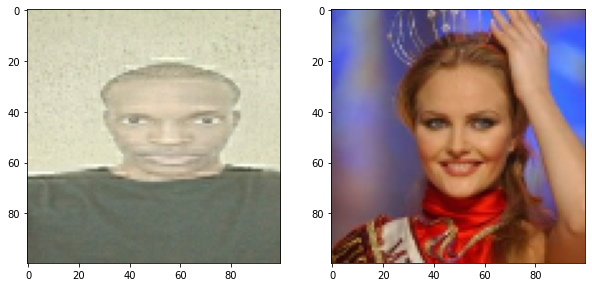

In [74]:
# set plot size
plt.figure(figsize=(10,8))

# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# renders cleanly
plt.show()

#Save Model

In [75]:
# save weights
siamese_model.save('siamesemodelv2.h5')

In [76]:
L1Dist

__main__.L1Dist

In [77]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [ ]:
# make predictions with reloaded model
siamese_model.predict([test_input, test_val])

In [79]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_ing (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         19823808    input_img[0][0]                  
                                                                 validation_ing[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     